In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import struct
import os
import math

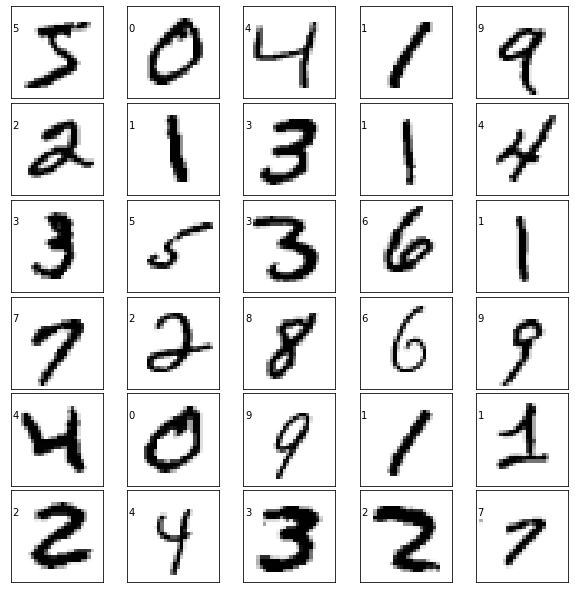

In [2]:
# 读取数据

# 参考博客：https://blog.csdn.net/u013597931/article/details/80099243
def load_mnist_train(path, kind='train'):    
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)    # 训练集的路径读取
    with open(labels_path, 'rb') as lbpath:          
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    return images, labels
def load_mnist_test(path, kind='t10k'):
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    return images, labels   

path='./mnist/raw/'
train_images,train_labels=load_mnist_train(path)    # 训练数据
test_images,test_labels=load_mnist_test(path)      # 测试数据

fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(30):
    images = np.reshape(train_images[i], [28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
    ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [3]:
# 数据规模
print(train_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(test_labels.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [4]:
# 数据归一化
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# 抽取一个小批量
Batch_size = 10000
batch_train = np.random.choice(np.arange(train_images.shape[0]), Batch_size)
batch_test = np.random.choice(np.arange(test_images.shape[0]), 2000)
train_images0 = train_images[batch_train]
train_labels0 = train_labels[batch_train]
test_images0 = test_images[batch_test]
test_labels0 = test_labels[batch_test]
print(train_images0.shape)

(10000, 784)


In [6]:
 np.seterr(divide='ignore', invalid='ignore')  # 忽略掉除于0的元素

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
# 全连接层的初始化类
class FullyConnected():
    def __init__(self, W, b):
        '''
        Parameter:
        W: 权重矩阵，形状为(N, M), N为输入神经元的个数，M为输出神经元的个数
        b: 偏移量矩阵 (M，)
        '''
        self.W = W    # 赋值
        self.b = b    # 赋值

        self.x = None      # 用来存储输入神经元的矩阵，为反向传播提供便利

        self.dW = None   # 用来存储梯度，梯度下降时需要用来更新权重
        self.db = None
    
    # 全连接层的前向传播
    def forward(self, x):
        '''
        input:
        x: 输入神经元的矩阵, 形状(B, N)，B为批量大小，N为输入神经元的个数
        output:
        y: 输出神经元的矩阵, 形状(B, M)， M为输出神经元的个数
        '''
        self.x = x            # 存储输入神经元的矩阵，便于反向传播计算更新权重
        out = np.dot(self.x, self.W) + self.b   # 完成一次前向传播
        return out    # 返回前向传播结果
    
    
    # 全连接层的反向传播
    def backward(self, dout):
        '''
        input:
        dout: 损失函数相对于全连接层输出的梯度，形状为(B,M)，M是全连接层的输出神经元个数。
        在前向传播时全连接层的输入记录在了self.x中，故由此我们可以利用dout和self.x得到W的梯度
        output:
        dx:  (B, N) 关于输入层的梯度，便于进一步反向传播
        self.W和self.b的梯度分别存储在self.dW和self.db中
        self.dW: (N, M) 与self.W形状相同，self.W的梯度
        self.db: (M,)， self.b的梯度
        将x的梯度返回。
        '''
        # 以下所有即为矩阵的求导方法，我们也可以根据形状输入输出求解
        # 均依赖于公式 Y = X^T + W
        self.db = np.sum(dout, axis=0)    # 需要将得到的所有dout延y轴相加，因为取loss是就除以了batch_size
        self.dW = np.dot(self.x.T, dout)  # 在前向传播时全连接层的输入记录在了self.x中，这一项根据矩阵求导得到我们结果
        dx = np.dot(dout, self.W.T)       # 由矩阵求导得出结果
        return dx                       # 返回对输入层求导的结果，便于记录进一步反向传播

In [8]:
# 激活函数的初始化类
class Sigmoid():
    '''
    Parameter:
    z:激活函数作用后得到的矩阵
    '''
    def __init__(self):
        self.z = None
    
    
    # Sigmoid激活函数的前向传播。
    def forward(self, y):
        '''
        input: 
        y:全连接层前向传播得到矩阵，形状为(B, N)
        output:
        z:激活函数作用后得到矩阵，形状为(B, N)
        '''
        z = np.exp(y) / (1 + np.exp(y)) # 利用np.exp直接对矩阵运算
        self.z = z   # 赋值
        return z  # 返回矩阵
    
    # sigmoid的反向传播
    def backward(self, dout):
        '''
        input: 
        dout：损失函数相对于sigmoid输出的梯度
        output:
        dz:相对于矩阵y得到的梯度
        '''
        dz = dout * self.z * (np.ones(self.z.shape) - self.z)
        return dz

class Relu:
    def __init__(self):
        '''
        Parameter:
        z:激活函数作用后得到的矩阵
        '''
        self.mask = None
    
    # Relu激活函数的前向传播。
    def forward(self, y):
        '''
        input: 
        y:全连接层前向传播得到矩阵，形状为(B, N)
        output:
        z:激活函数作用后得到矩阵，形状为(B, N)
        '''
        self.mask = (y <= 0)   # 得到关于y大于小于0的真值的矩阵
        z = y.copy()       # 深度拷贝一个y矩阵
        z[self.mask] = 0   # 将小于零的值赋为0
        return z   # 返回矩阵

    def backward(self, dout):
        '''
        input: 
        dout：损失函数相对于relu输出的梯度
        output:
        dz:相对于矩阵y得到的梯度
        '''
        dout[self.mask] = 0
        dz = dout
        return dz

In [9]:
# 误差损失函数的类定义（Cross Entropy+softmax)
# 激活函数softmax
def softmax(y):
    '''
    input:
    y:最终得到的预测输出结果矩阵
    output:
    将其使用softmax归一化返回处理后的矩阵（利于计算损失函数）
    '''
    y = y - np.max(y, axis=1, keepdims=True)     # 防止产生exp溢出的危险，所以每一行都减去最大值，且由加减值性质易得不会对值产生影响
    return np.exp(y) / np.sum(np.exp(y), axis=1, keepdims=True)   # 返回softmax处理后矩阵，利于进一步计算损失函数

# 类定义
class SoftmaxWithLoss():
    '''
    Parameter:
    y : 预测输出结果矩阵，需要进一步softmax处理并利用其求出误差损失，形状为(B, 10)
    label: 真实标签矩阵，形状为 (B， 1)
    '''
    
    def __init__(self):
        self.loss = None
        self.z = None
        self.label = None
    
    # SoftMax + Cross Entropy的前向传播
    def forward(self, y, label):
        '''
        input:
        y : 预测输出结果矩阵，需要进一步softmax处理并利用其求出误差损失，形状为(B, 10)
        label: 真实标签矩阵，形状为 (B， 1)
        output:
        loss: 交叉熵损失
        '''
        z = softmax(y)      # 使用激活函数将输出矩阵归一化
        batch_size = z.shape[0]   # 得到batch_size
        loss = -np.sum(np.log(z[np.arange(batch_size), label])) / batch_size    # 求出平均损失误差值，使用交叉熵，利用one-hot特性得到每组输入的log值
#                 loss = -np.sum(np.log(z[np.arange(batch_size), t] + 1e-7)) / batch_size
        self.loss = loss  # 记录损失值
        self.z = z     
        self.label = label    # 存储记录
        return loss    # 返回误差损失
    
    # SoftMax + Cross Entropy的反向传播
    def backward(self):
        '''
        output:
        交叉熵+softmax梯度
        '''
        batch_size = self.z.shape[0]  # 得到batch_size
        dz = np.copy(self.z)       # 深拷贝
        for label_, z_ in zip(self.label, dz):   # 由求梯度+onehot编码推出仅需在真实值所在位置减1即得梯度
            z_[label_] -= 1
        dz /= batch_size   # 取平均
        return dz   # 返回梯度

In [10]:
# 神经网络实现
class Network:
    # 初始化
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=10, lr=0.1):
        '''
        Parameters:
        input_size, hidden_size1, hidden_size2, output_size:
        分别为输入层神经元个数、隐藏层神经元数、隐藏层神经元个数、输出层神经元个数数(手写数字识别默认为10), 学习率(默认为0.1)
        output:None
        '''
        W1 = np.random.randn(input_size, hidden_size1)  # 随机初始化权重
        W2 = np.random.randn(hidden_size1, hidden_size2)
        W3 = np.random.randn(hidden_size2, output_size)
        b1 = np.random.randn(hidden_size1)
        b2 = np.random.randn(hidden_size2)
        b3 = np.random.randn(output_size)
        
        
        self.lr = lr     # 学习率
        self.layer_1 = FullyConnected(W1, b1)
        self.sigmoid_1 = Sigmoid()
        self.layer_2 = FullyConnected(W2, b2)
        self.sigmoid_2 = Sigmoid()
        self.layer_last = FullyConnected(W3, b3)
        self.loss = SoftmaxWithLoss()
    
    # 神经网络前向传播
    def forward(self, x, label):
        '''
        input:
        x: 形状为(B,N)，输入的原始数据， B为批量Batch_size
        label:输入B个数据的分类类别，形状为(B, 1)
        output:
        最后输出的预测向量以及我们得到的误差
        '''
        y1 = self.layer_1.forward(x)  # 前向传播，一步步往后走
        z1 = self.sigmoid_1.forward(y1)
        y2 = self.layer_2.forward(z1)
        z2 = self.sigmoid_2.forward(y2)
        y3 = self.layer_last.forward(z2)
        loss = self.loss.forward(y3, label)
        
        return y3, loss
    
    
    # 神经网络反向传播
    def backward(self):
        '''
        input:None
        output:
        各项参数的梯度
        '''
        d = self.loss.backward()     # 反向传播，一步步往前走，和前向完全相反
        d = self.layer_last.backward(d)
        d = self.sigmoid_2.backward(d)
        d = self.layer_2.backward(d)
        d = self.sigmoid_1.backward(d)
        d = self.layer_1.backward(d)    # 至此，我们单次反向传播完成。
        
        return self.layer_1.dW, self.layer_1.db, self.layer_2.dW, self.layer_2.db, self.layer_last.dW, self.layer_last.db  # 将每层间权重的W 、偏移量b梯度返回
        # 这一步只是为了方便检查展示，并没有很大的用途


    # 神经网络更新权重
    def refresh(self):
        lr = self.lr
        self.layer_1.W -= lr * self.layer_1.dW
        self.layer_1.b -= lr * self.layer_1.db
        self.layer_2.W -= lr * self.layer_2.dW
        self.layer_2.b -= lr * self.layer_2.db
        self.layer_last.W -= lr * self.layer_last.dW
        self.layer_last.b -= lr * self.layer_last.db
    
    # 训练模型并判断正确率
    def fit_pred(self, train_images, train_labels, test_images, test_labels, Epochs=5, batch_size=100):
        '''
        input：
        train_images:训练集
        test_labels:测试集
        output:None
        '''
        samples_num = train_images.shape[0]   # 得到训练集数量
        for epoch in range(1, Epochs + 1):   # 在训练集里面跑5次
            i = 0
            while i < samples_num:
                self.forward(train_images[i:i+batch_size], train_labels[i:i+batch_size])  # 每次训练batch_size个样本
                self.backward()         # 反向传播
                self.refresh()          # 更新参数
#                 print("Train Epoch: {}\t batch_size_index:{} Loss:{:.6f}".format(epoch, i+1, self.loss.loss))
                i += batch_size
                
#             self.lr = (0.95 ** epoch) * self.lr     # 更新学习率，防止其因为学习率过大而导致无法有效下降。
            print("Train Epoch: {}\t Loss:{:.6f}".format(epoch, self.loss.loss))
            pred, pred_loss, right_rate = self.predict(test_images, test_labels)    # 计算测试集精度
            print("Test -- Average loss:{:.4f}, Accuracy:{:.3f}\n".format(pred_loss, right_rate))
    
    # 预测模型
    def predict(self, test_images, test_labels):
        '''
        '''
        pred, loss = self.forward(test_images, test_labels)  # 预测值和损失
        pred = np.argmax(pred, axis=1)   # 求出预测标签
        return pred, loss, right_rate(pred, test_labels)   # 返回预测值向量和损失误差以及正确率。
    

In [11]:
# 计算预测数据正确率
def right_rate(pred_label, label):
    '''
    input:
    pred_label:预测的结果数组
    label:实际的类别数组
    output:
    rate:正确率
    '''
    diff = pred_label - label
    return diff.tolist().count(0) / len(diff)

In [12]:
a = Network(784, 200, 100, lr=0.1)
a.fit_pred(train_images,train_labels, test_images, test_labels, Epochs=50)

Train Epoch: 1	 Loss:1.139331
Test -- Average loss:1.0151, Accuracy:0.674

Train Epoch: 2	 Loss:0.820274
Test -- Average loss:0.7489, Accuracy:0.762

Train Epoch: 3	 Loss:0.713222
Test -- Average loss:0.6330, Accuracy:0.802

Train Epoch: 4	 Loss:0.646186
Test -- Average loss:0.5658, Accuracy:0.827

Train Epoch: 5	 Loss:0.591296
Test -- Average loss:0.5200, Accuracy:0.843

Train Epoch: 6	 Loss:0.549682
Test -- Average loss:0.4858, Accuracy:0.855

Train Epoch: 7	 Loss:0.516390
Test -- Average loss:0.4592, Accuracy:0.863

Train Epoch: 8	 Loss:0.487957
Test -- Average loss:0.4380, Accuracy:0.871

Train Epoch: 9	 Loss:0.462826
Test -- Average loss:0.4206, Accuracy:0.876

Train Epoch: 10	 Loss:0.439662
Test -- Average loss:0.4058, Accuracy:0.881

Train Epoch: 11	 Loss:0.418024
Test -- Average loss:0.3928, Accuracy:0.884

Train Epoch: 12	 Loss:0.398351
Test -- Average loss:0.3814, Accuracy:0.888

Train Epoch: 13	 Loss:0.381083
Test -- Average loss:0.3712, Accuracy:0.890

Train Epoch: 14	 Loss

In [14]:
a.lr = 0.03
a.fit_pred(train_images,train_labels, test_images, test_labels, Epochs=20)

Train Epoch: 1	 Loss:0.241022
Test -- Average loss:0.2358, Accuracy:0.932

Train Epoch: 2	 Loss:0.241101
Test -- Average loss:0.2356, Accuracy:0.932

Train Epoch: 3	 Loss:0.241026
Test -- Average loss:0.2355, Accuracy:0.932

Train Epoch: 4	 Loss:0.240893
Test -- Average loss:0.2353, Accuracy:0.932

Train Epoch: 5	 Loss:0.240738
Test -- Average loss:0.2351, Accuracy:0.932

Train Epoch: 6	 Loss:0.240576
Test -- Average loss:0.2350, Accuracy:0.932

Train Epoch: 7	 Loss:0.240413
Test -- Average loss:0.2348, Accuracy:0.932

Train Epoch: 8	 Loss:0.240250
Test -- Average loss:0.2346, Accuracy:0.932

Train Epoch: 9	 Loss:0.240089
Test -- Average loss:0.2345, Accuracy:0.932

Train Epoch: 10	 Loss:0.239931
Test -- Average loss:0.2343, Accuracy:0.932

Train Epoch: 11	 Loss:0.239774
Test -- Average loss:0.2342, Accuracy:0.932

Train Epoch: 12	 Loss:0.239620
Test -- Average loss:0.2340, Accuracy:0.932

Train Epoch: 13	 Loss:0.239467
Test -- Average loss:0.2338, Accuracy:0.932

Train Epoch: 14	 Loss

In [15]:
a.lr = 0.01
a.fit_pred(train_images,train_labels, test_images, test_labels, Epochs=20)

Train Epoch: 1	 Loss:0.237625
Test -- Average loss:0.2327, Accuracy:0.933

Train Epoch: 2	 Loss:0.237572
Test -- Average loss:0.2326, Accuracy:0.933

Train Epoch: 3	 Loss:0.237539
Test -- Average loss:0.2325, Accuracy:0.933

Train Epoch: 4	 Loss:0.237496
Test -- Average loss:0.2325, Accuracy:0.933

Train Epoch: 5	 Loss:0.237444
Test -- Average loss:0.2324, Accuracy:0.933

Train Epoch: 6	 Loss:0.237385
Test -- Average loss:0.2323, Accuracy:0.933

Train Epoch: 7	 Loss:0.237323
Test -- Average loss:0.2322, Accuracy:0.934

Train Epoch: 8	 Loss:0.237258
Test -- Average loss:0.2322, Accuracy:0.934

Train Epoch: 9	 Loss:0.237191
Test -- Average loss:0.2321, Accuracy:0.934

Train Epoch: 10	 Loss:0.237124
Test -- Average loss:0.2320, Accuracy:0.934

Train Epoch: 11	 Loss:0.237057
Test -- Average loss:0.2320, Accuracy:0.934

Train Epoch: 12	 Loss:0.236989
Test -- Average loss:0.2319, Accuracy:0.934

Train Epoch: 13	 Loss:0.236922
Test -- Average loss:0.2318, Accuracy:0.934

Train Epoch: 14	 Loss